<table style="width:100%">
<tr>
<td style="vertical-align:middle; text-align:left;">
<font size="2">
Supplementary code for the <a href="http://mng.bz/orYv">Build a Large Language Model From Scratch</a> book by <a href="https://sebastianraschka.com">Sebastian Raschka</a><br>
<br>Code repository: <a href="https://github.com/rasbt/LLMs-from-scratch">https://github.com/rasbt/LLMs-from-scratch</a>
<br>汉化的库: <a href="https://github.com/GoatCsu/CN-LLMs-from-scratch.git">https://github.com/GoatCsu/CN-LLMs-from-scratch.git</a>
</font>
</td>
<td style="vertical-align:middle; text-align:left;">
<a href="http://mng.bz/orYv"><img src="../image/cover-small.webp" width="100px"></a>
</td>
</tr>
</table>


# 第七章：指令微调

In [1]:
from importlib.metadata import version

pkgs = [
    "matplotlib",  # 绘图库
    "tiktoken",    # 分词器
    "torch",       # 深度学习库
    "tqdm",        # 进度条
    "tensorflow",  # 用于加载OpenAI的预训练权重
]
for p in pkgs:
    print(f"{p} version: {version(p)}")
# 读取并输出版本号

matplotlib version: 3.7.1
tiktoken version: 0.7.0
torch version: 2.4.0
tqdm version: 4.66.4
tensorflow version: 2.15.0


<img src="../image/1.png" width=500px>

## 7.1 指令微调的介绍

- 在第5章中，我们看到大语言模型的预训练是通过让模型学习逐个生成单词来实现的。
- 由此可见,预训练的大语言模型擅长文本补全的任务，但不擅长执行指令。
- 在本章中，我们将微调大语言模型使其更好地遵循指令。

<img src="../image/2.png" width=500px>

- 在下图中,你可以看到本章节所涉及的话题

<img src="../image/3.png" width=500px>

## 7.2 为有监督指令微调准备数据集

- 使用我为本章准备的一个指令数据集

In [2]:
import json
import os
import urllib


def download_and_load_file(file_path, url):

    if not os.path.exists(file_path):
        with urllib.request.urlopen(url) as response:
            text_data = response.read().decode("utf-8")
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)
    else:
        with open(file_path, "r", encoding="utf-8") as file:
            text_data = file.read()

    with open(file_path, "r", encoding="utf-8") as file:
        data = json.load(file)

    return data
# 在网上下载并打开数据库

file_path = "instruction-data.json"
url = (
    "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch"
    "/main/ch07/01_main-chapter-code/instruction-data.json"
)

data = download_and_load_file(file_path, url)
print("Number of entries:", len(data))
# 看一下数据一共有多少条

Number of entries: 1100


- 每个我们从上述 JSON 文件加载的 `data` 列表中的项都是一个字典，格式如下：

In [3]:
print("Example entry:\n", data[50])
# 打印第51个json的形式

Example entry:
 {'instruction': 'Identify the correct spelling of the following word.', 'input': 'Ocassion', 'output': "The correct spelling is 'Occasion.'"}


- 有时输入也可能是空的，如下所示

In [4]:
print("Another example entry:\n", data[999])

Another example entry:
 {'instruction': "What is an antonym of 'complicated'?", 'input': '', 'output': "An antonym of 'complicated' is 'simple'."}


- 指令微调通常被称为“监督指令微调”，因为它涉及在一个数据集上训练模型，而该数据集中明确提供了输入-输出对。
- 有多种不同的方法可以将样本制作为适应于大语言模型的格式；下图分别展示了两种用于训练Alpaca（[https://crfm.stanford.edu/2023/03/13/alpaca.html](https://crfm.stanford.edu/2023/03/13/alpaca.html)）和Phi-3（[https://arxiv.org/abs/2404.14219](https://arxiv.org/abs/2404.14219)）LLM的示例格式。

<img src="../image/4.png" width=500px>

- 在本章中，我们默认使用Alpaca风格的提示格式，这是一种较早公开并被广泛使用的指令微调提示模板。
- 下面，我们将格式化输入内容，并将其作为输入传递给大语言模型。

In [5]:
def format_input(entry):
    """
    将单个数据条目格式化为 Alpaca 风格的提示格式（prompt）。
    适用于指令微调任务，使文本内容能直接用于大语言模型输入。

    参数
    ----
    entry : dict
        包含键 'instruction'（指令/需求描述）、'input'（附加输入，可能为空），
        还有 'output'（期望模型输出，未在本函数处理）。

    返回
    ----
    prompt : str
        格式化后的多行字符串，包含固定模板、Instruction 和可选的 Input 字段。

    示例
    ----
    entry = {
        "instruction": "将下列英文翻译成中文。",
        "input": "I love learning artificial intelligence.",
        ...
    }
    format_input(entry)
    # 返回:
    # Below is an instruction that describes a task. Write a response that appropriately completes the request.
    #
    # ### Instruction:
    # 将下列英文翻译成中文。
    #
    # ### Input:
    # I love learning artificial intelligence.
    """

    # 拼接任务描述和Instruction部分（固定说明 + 来自 entry['instruction']）
    instruction_text = (
        "Below is an instruction that describes a task. "
        "Write a response that appropriately completes the request."
        "\n\n### Instruction:\n"
        f"{entry['instruction']}"
    )

    # 如果 'input' 字段非空，则添加 Input 部分，否则不添加（例如有些任务无需附加输入）
    if entry["input"]:
        input_text = f"\n\n### Input:\n{entry['input']}"
    else:
        input_text = ""  # 没有输入时，该部分为空字符串

    # 合并成最终 prompt；注意模型微调通常还需拼接 output 部分
    return instruction_text + input_text

- 格式化的回复如下所示

In [6]:
model_input = format_input(data[50])
desired_response = f"\n\n### Response:\n{data[50]['output']}"
# 先使用五十条数据进行测试
print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Identify the correct spelling of the following word.

### Input:
Ocassion

### Response:
The correct spelling is 'Occasion.'


- 以下是一个没有输入内容对应的格式化响应：

In [7]:
model_input = format_input(data[999])
desired_response = f"\n\n### Response:\n{data[999]['output']}"

print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What is an antonym of 'complicated'?

### Response:
An antonym of 'complicated' is 'simple'.


- 最后，在下一节中准备 PyTorch 数据加载器之前，我们将数据集划分为训练集、验证集和测试集。

In [8]:
# 自定义训练集、测试集和验证集的大小
train_portion = int(len(data) * 0.85)  # 85% 作为训练集
test_portion = int(len(data) * 0.1)    # 10% 作为测试集
val_portion = len(data) - train_portion - test_portion  # 剩下的 5% 作为验证集

# 划分数据集
train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]


In [9]:
print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

Training set length: 935
Validation set length: 55
Test set length: 110


## 7.3 将数据组织成训练批次

<img src="../image/5.png" width=500px>

- 下图总结了我们处理数据的几种方式

<img src="../image/6.png" width=500px>

- 首先，我们实现一个 `InstructionDataset` 类，它对数据集中的所有输入进行预分词，类似于第6章中的 `SpamDataset`。

<img src="../image/7.png" width=500px>

In [10]:
import torch
from torch.utils.data import Dataset

class InstructionDataset(Dataset):
    """
    自定义数据集类，用于将原始指令数据（如 Alpaca 格式）转成模型可用的 token 编码序列。
    """
    def __init__(self, data, tokenizer):
        """
        :param data: 一个包含多条指令-输入-输出字典的列表，每条如 {'instruction': ..., 'input': ..., 'output': ...}
        :param tokenizer: 分词器对象，比如 tiktoken 编码器，需支持 .encode(str) 方法
        """
        self.data = data  # 原始数据列表

        # 存储所有处理好的 token id 序列
        self.encoded_texts = []

        for entry in data:
            # 1. 格式化用户 prompt，比如加上 "### Instruction" 等头
            instruction_plus_input = format_input(entry)

            # 2. 格式化期望的答案标签，与原数据 output 拼接（前加换行及 Response 前缀）
            response_text = f"\n\n### Response:\n{entry['output']}"

            # 3. 合并为模型训练的目标文本（你训练的就是输入输出对）
            full_text = instruction_plus_input + response_text

            # 4. 用 tokenizer 预编码成 token id 列表
            self.encoded_texts.append(
                tokenizer.encode(full_text)
            )

    def __getitem__(self, index):
        """
        支持下标访问：dataset[idx] 返回第 idx 个训练样本的 token id 列表（已编码）
        """
        return self.encoded_texts[index]

    def __len__(self):
        """
        返回数据集长度，等于原始数据的条数
        """
        return len(self.data)

- 与第6章类似, 为了加速训练, 我们希望将多个批次收集到同个训练轮次中, 这要求将所有输入填充到相同的长度。
- 同样与上一章类似，我们使用 `<|endoftext|>` 作为填充 token。

In [11]:
import tiktoken  # 导入 tiktoken 库，用于加载和使用高效的分词器（tokenizer）

# 加载 GPT-2 的编码器（分词器），常用于 OpenAI 系列的 LLM 训练和推理
# 这个编码器会将字符串转换为 token ID 序列，与 GPT-2 及许多社区 LLM 数据集格式兼容
tokenizer = tiktoken.get_encoding("gpt2")  # "gpt2" 是内置的编码模型名称

# 测试编码一个特殊 token：<|endoftext|>
# allowed_special={"<|endoftext|>"} 参数表示明确允许对特殊的 <|endoftext|> token 编码
# 通常 <|endoftext|> 被用作“文本结束”或者“填充”标记，不在普通词表中，需专项允许
# 输出其对应的 token id 列表，确认分词器配置无误
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


- 在第6章中，我们将数据集中的所有例子填充为相同的长度。
  - 而在这里，我们采取了一种更为复杂的方法: 开发了一个自定义的 "collate" 函数，并将其传递给数据加载器。
  - 这个自定义的collate函数会将每个批次中的训练示例填充到相同的长度（不同批次的长度可以不同）。

<img src="../image/8.png" width=500px>

In [12]:
def custom_collate_draft_1(
    batch,
    pad_token_id=50256,
    device="cpu"
):
    """
    自定义的collate函数，用于将一个批次的序列填充到相同长度，并生成输入张量。
    
    参数说明:
        batch: 一个批次的样本, 例如 [[1,2,3], [4,5], [6,7,8,9]]
        pad_token_id: 用于填充的token的id，默认为GPT-2中的<|endoftext|>的id: 50256
        device: 输出张量要放置的设备，"cpu" 或 "cuda"
    返回:
        形状为 (batch_size, max_length) 的张量，每一行是填充后的输入序列
    """

    # Step 1: 计算本批次中长度最长的序列，加1是为了在末尾额外添加一个pad_token
    # 这样可以确保后续的target序列和input序列能错位一位（适用于下游因果语言建模）
    batch_max_length = max(len(item)+1 for item in batch)  # +1表示每句话后面加个pad

    inputs_lst = []  # 用于存储每个样本的张量化输入
    # Step 2: 对每个序列独立处理
    for item in batch:
        # 由于item是list，这里需要copy，否则会就地修改原始数据（小心副作用）
        new_item = item.copy()  
        # 在每个样本末尾先加一个pad_token_id，实现+1长度的需求
        new_item += [pad_token_id]
        # Step 3: 如果当前序列长度还不足最大长度，则继续填充pad到满足batch_max_length
        # - (batch_max_length - len(new_item)) 保证补全到等长
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        # Step 4: 由于最后一位加的pad只是为了target错位输入，不需要作为input token，需裁剪掉
        # 保证最后返回的inputs张量形状统一且不多余
        inputs = torch.tensor(padded[:-1])
        # 将当前样本的tensor结果加入列表
        inputs_lst.append(inputs)
    # Step 5: 将所有输入张量用stack拼接为(batch_size, seq_len)，并搬到指定device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    
    return inputs_tensor

In [13]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = (
    inputs_1,
    inputs_2,
    inputs_3
)

print(custom_collate_draft_1(batch))

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])


<img src="../image/9.png" width=500px>

- 上述内容中，我们仅返回了给大语言模型的输入。
- 然而，对于大语言模型的训练，我们还需要目标值。
- 与我们在预训练大语言模型时的做法相似，目标token序号与输入token序号相对应，但相比起来向右移动了一个位置（见下图），这样的设计使得大语言模型能够学习如何预测序列中的下一个词元。

<img src="../image/10.png" width=400px>

In [14]:
def custom_collate_draft_2(
    batch,
    pad_token_id=50256,  # 默认填充ID使用GPT-2的<|endoftext|> token
    device="cpu"
):
    # 步骤1：计算本批次中需要对齐（补齐填充）的目标最大长度
    # 这里为每个样本增加1个token长度，是因为后续会拼接上一个pad_token_id，便于构造target序列
    batch_max_length = max(len(item) + 1 for item in batch)

    # 步骤2：初始化两个空列表，分别用于存放每个样本的input和target序列
    # - inputs_lst：存放每个样本处理后的输入序列
    # - targets_lst：存放每个样本对应的目标序列
    inputs_lst, targets_lst = [], []
    
    for item in batch:
        # 步骤3：创建当前样本的拷贝，避免修改原始数据
        new_item = item.copy()
        # 步骤4：追加一个pad_token_id，作为当前序列的“结束”标志（和target错位时对齐）
        new_item += [pad_token_id]

        # 步骤5：按规定长度补全padding到batch_max_length
        #   - 计算还需要补多少pad_token_id，使总长度一致
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )

        # 步骤6：构造模型的输入序列(inputs)
        #   - inputs是padded的从第一个元素到倒数第二个元素
        #   - 这样处理后，inputs的长度为 batch_max_length-1
        inputs = torch.tensor(padded[:-1]) 

        # 步骤7：构造目标序列(targets)
        #   - targets是padded的从第二个元素到最后一个元素
        #   - 目的：输入序列与目标序列错位一位，使得模型每一步都以timestep t的token预测下一个t+1的token
        #   - 长度也为batch_max_length-1，与inputs完全对齐
        targets = torch.tensor(padded[1:]) 
        
        # 步骤8：将当前样本的inputs和targets加入对应列表
        inputs_lst.append(inputs)
        targets_lst.append(targets)

    # 步骤9：将所有样本的inputs和targets分别拼接为形状为(batch_size, seq_len)的大张量
    #       并转移到指定的device（如'cuda'或'cpu'）
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)

    # 步骤10：返回拼接好的inputs和targets张量
    return inputs_tensor, targets_tensor

In [15]:
inputs, targets = custom_collate_draft_2(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256, 50256, 50256, 50256],
        [    8,     9, 50256, 50256, 50256]])


- 接下来，我们引入了一个 `ignore_index` 值，用于将所有填充 token 的ID替换为一个新值；引入 `ignore_index` 的目的是使我们能够在损失函数中忽略填充值（稍后会详细讨论）。

<img src="../image/11.png" width=500px>

- 具体来说，这意味着我们将 `50256` 对应的 token ID替换为 `-100`，如图所示。

<img src="../image/12.png" width=500px>

- （此外，我们还引入了 `allowed_max_length`，以支持“限制样本的长度”。如果您打算使用比GPT-2模型支持的1024个 token 上下文长度更长的数据集，这个设置将非常有用）

In [16]:
def custom_collate_fn(
    batch,
    pad_token_id=50256,
    ignore_index=-100,
    allowed_max_length=None,
    device="cpu"
):
    """
    自定义collate函数，用于将一个batch内的变量长度样本整理成统一格式的张量，
    并处理填充、目标（targets）及可选的最大序列长度。
    
    参数说明:
        batch: List[List[int]]
            小批量样本，每个元素是一个token id序列（长度各异）。
        pad_token_id: int
            用于填充的token id，默认为GPT-2的<|endoftext|>的id: 50256。
        ignore_index: int
            在计算损失时要忽略的填充值，例如CrossEntropyLoss默认-100。
        allowed_max_length: int or None
            （可选）如果设置，限制最终输入/目标序列的最大长度。
        device: str
            张量最终转移到的设备（'cpu' 或 'cuda'）。
    返回:
        inputs_tensor: torch.LongTensor, shape [batch_size, seq_len]
            拼接好的inputs张量。
        targets_tensor: torch.LongTensor, shape [batch_size, seq_len]
            拼接好的targets张量，填充部分已替换为ignore_index。
    """

    # 步骤1：确定当前batch内的最大序列长度
    #   - +1 是因为后面每个序列都要额外加一个 <|endoftext|> token
    batch_max_length = max(len(item) + 1 for item in batch)

    # 用于收集处理后的每个样本的输入（inputs）和目标（targets）张量
    inputs_lst, targets_lst = [], []

    # 步骤2：逐个处理batch里的每个样本
    for item in batch:
        # 2.1 拷贝原始序列，避免原数据污染
        new_item = item.copy()

        # 2.2 在序列末尾拼接一个 <|endoftext|> (pad_token_id)，使模型学到文本结束
        new_item += [pad_token_id]

        # 2.3 进行padding补齐到batch内最大长度
        #    - padding的token也是pad_token_id
        padded = new_item + [pad_token_id] * (batch_max_length - len(new_item))

        # 2.4 划分inputs和targets
        #     - inputs: padded的前n-1个token（不包含最后一个）
        #     - targets: padded的后n-1个token（首位剔除，右移1位）
        inputs = torch.tensor(padded[:-1])   # 作为模型输入
        targets = torch.tensor(padded[1:])   # 作为下一个token预测目标

        # 2.5 【填充值处理】为了后续损失计算时忽略填充token，在targets中，
        #     - 除第一个pad_token_id出现外，其余pad都替换为ignore_index
        #     - 这里的mask等于True的位置就是pad_token_id
        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        # 只有在出现2次及以上pad_token_id时才处理(首个保留, 后面换为ignore_index)
        if indices.numel() > 1:
            # indices是 pad_token 的下标，将下标1及以后全部设为ignore_index（保留第一个pad_token_id）
            targets[indices[1:]] = ignore_index

        # 2.6 （可选）如果设置了最大长度，截断inputs和targets
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]

        # 2.7 收集本样本处理好的inputs和targets
        inputs_lst.append(inputs)
        targets_lst.append(targets)

    # 步骤3：将所有样本堆叠、转为大张量，并放到目标设备
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)

    # 步骤4：返回inputs和targets张量
    return inputs_tensor, targets_tensor

In [17]:
inputs, targets = custom_collate_fn(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256,  -100,  -100,  -100],
        [    8,     9, 50256,  -100,  -100]])


- 看看填充 token 替换为 -100 产生了什么效果。
- 为了说明，假设我们有一个小型分类任务，包含两个类标签，0和1，类似于第6章的内容。
- 如果有以下的logits值（模型最后一层的输出），我们可以计算出以下的损失。

In [18]:
# 这段代码用于演示如何用 PyTorch 的 cross_entropy 函数计算分类问题的损失
import torch

# logits_1 是一个二维 Tensor，每一行表示一个样本在两个类别上的模型输出分数
# 第一个样本的输出：[-1.0, 1.0]；第二个样本输出：[-0.5, 1.5]
logits_1 = torch.tensor(
    [[-1.0, 1.0],  # 第1个训练样本
     [-0.5, 1.5]]  # 第2个训练样本
)

# targets_1 表示每个样本的真实类别标签，分别是类别0和类别1
targets_1 = torch.tensor([0, 1])

# 计算交叉熵损失（cross entropy loss），即对每个样本，
# 根据其 logits 和真实标签求平均损失。这也是分类任务常用的损失函数
loss_1 = torch.nn.functional.cross_entropy(logits_1, targets_1)

# 输出交叉熵损失的结果（是一个标量 Tensor）
print(loss_1)

# 运行结果大致为 0.313 (不同设备或数值环境可能有轻微差异)
# 解释：此结果表示模型当前预测与真实标签的平均不一致程度，数值越小通常说明模型性能越好。

tensor(1.1269)


- 显然,多了一个token会影响loss

In [19]:
logits_2 = torch.tensor(
    [[-1.0, 1.0],
     [-0.5, 1.5],
     [-0.5, 1.5]]  # 新增第3个训练实例
)
targets_2 = torch.tensor([0, 1, 1])

loss_2 = torch.nn.functional.cross_entropy(logits_2, targets_2)
print(loss_2)

tensor(0.7936)


- 但是我们看看如果这个token变成了-100会怎样

In [20]:
targets_3 = torch.tensor([0, 1, -100])

loss_3 = torch.nn.functional.cross_entropy(logits_2, targets_3)
print(loss_3)
print("loss_1 == loss_3:", loss_1 == loss_3)
# 综上所述、交叉熵会忽略-100

tensor(1.1269)
loss_1 == loss_3: tensor(True)


- 如上述所见，这3个训练样本计算得到的损失与我们从2个样本计算得到的损失相同，可以看出交叉熵损失函数忽略了带有 -100 标签的训练样本。
- 默认情况下，PyTorch 的 `cross_entropy(..., ignore_index=-100)` 设置会忽略对应于标签 -100 的样本。
- 使用这个 -100 的 `ignore_index`，我们可以忽略在批次中填充训练样本到相同长度时使用的额外结束 token（填充 token）。
- 然而，我们忽略第一个结束 token（50256）也不是个好选择，因为这个 token 有助于向LLM发出**响应已完成**的信号。

- 除了屏蔽填充词元，实践中我们通常还会屏蔽与指令相关的目标token ID（这是本章节的练习）。

<img src="../image/13.png" width=600px>

## 7.4 创建指令数据集的数据加载器

- 在本节中，我们使用 `InstructionDataset` 类和 `custom_collate_fn` 函数来实例化训练集、验证集和测试集数据加载器。

<img src="../image/14.png" width=500px>

- 之前的 `custom_collate_fn` 函数的另一个改进之处在于，我们现在直接将数据移动到目标设备（例如GPU），而不是在主训练循环中执行。这提高了效率，因为当我们将 `custom_collate_fn` 作为数据加载器的一部分使用时，数据的移动可以在后台进行。
- 我们使用 Python 标准库中的 `functools` 模块的 `partial` 函数，创建了一个新函数，其中原始函数的 `device` 参数已预先填充。

In [21]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 注意：
# 如果适用，取消注释以下行将使代码能够在Apple Silicon芯片上运行，
# 这比在Apple CPU上运行要快得多（在M3 MacBook Air上测得）。
# 然而，计算得到的loss可能会略有不同。

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print("Device:", device)

Device: cuda


In [22]:
from functools import partial

# 使用 functools.partial 创建一个“定制化”的 collate 函数，用于 DataLoader 数据批处理
# 解释：collate_fn 通常需要传入一些参数（如 device、最大长度等），但是 DataLoader 只支持接收一个函数的引用作为参数。
# 因此，我们可以用 partial 先把 custom_collate_fn 里的参数“冻结/填充”好，返回一个新函数，这样 DataLoader 只需调用该新函数即可。

# 参数说明：
# - custom_collate_fn: 我们自定义的批量聚合函数，会负责把一批数据拼接、填充对齐、转成张量、移动到设备等
# - device: 当前目标设备（如 CPU、GPU 或 Apple MPS），数据会被直接拷贝到该设备，提高训练效率
# - allowed_max_length: 限制序列最大长度，超长时截断（避免显存溢出等）

customized_collate_fn = partial(
    custom_collate_fn,            # 目标批量聚合函数
    device=device,                # 固定参数：数据放到指定的设备上
    allowed_max_length=1024       # 固定参数：最大允许长度为 1024
)

# customized_collate_fn 现在就是一个"带默认参数"的新函数，只需要 (batch) 一个输入
# 之后可以直接传给 DataLoader 的 collate_fn 参数，无需再每次手动传 device/allowed_max_length

- 接下来，我们像之前的章节一样实例化数据加载器，唯一不同的是，我们现在为批处理过程提供了自定义的collate函数。

In [23]:
from torch.utils.data import DataLoader

# 设置DataLoader的一些参数
num_workers = 0         # 启用多少个子进程来加载数据。0表示只用主进程加载，适合Jupyter等交互环境和小数据集
batch_size = 8          # 每个训练批次的样本数。通常可以根据GPU/CPU内存适当调整，如8、16、32等

torch.manual_seed(123)  # 设置随机种子，以确保实验的可复现性（如shuffle、采样结果固定）

# 构建训练集的自定义Dataset对象，
# InstructionDataset 负责把原始指令数据train_data处理成模型可用的格式（分词、转token id等）
train_dataset = InstructionDataset(train_data, tokenizer)

# 实例化训练数据加载器DataLoader，负责后续批量取数据供模型训练
train_loader = DataLoader(
    train_dataset,                     # 传入自定义Dataset对象
    batch_size=batch_size,             # 每批的样本数
    collate_fn=customized_collate_fn,  # 自定义批量聚合与padding函数（如自动填充、转tensor、送device等）
    shuffle=True,                      # 每轮训练前随机打乱数据，有助于提升泛化能力
    drop_last=True,                    # 若最后剩余数据不足一个batch，就丢弃（避免batch size不一致导致的问题）
    num_workers=num_workers            # 数据加载用的进程数，0表示不开子进程，只用主线程
)


In [24]:
# 初始化验证与测试
val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)


- 看看输入和输出批次的维度是怎样的

In [25]:
print("Train loader:")
for inputs, targets in train_loader:
    print(inputs.shape, targets.shape)

Train loader:
torch.Size([8, 61]) torch.Size([8, 61])
torch.Size([8, 76]) torch.Size([8, 76])
torch.Size([8, 73]) torch.Size([8, 73])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 72]) torch.Size([8, 72])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 75]) torch.Size([8, 75])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 77]) torch.Size([8, 77])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 79]) torch.Size([8, 79])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 66]) torch.Size([8, 66])
torch.Size([8, 83]) torch.Size([8, 83])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 68]) torch.

- 如上面的输出所示，所有批次的批次大小为8，但长度各不相同，正如预期的那样。
- 我们还可以通过输出 `inputs` 批次中第一个训练样本的内容，再次确认输入中包含了与 token ID 50256 对应的 `<|endoftext|>` 填充 token。

In [26]:
print(inputs[0])

tensor([21106,   318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,
          257,  2882,   326, 20431, 32543,   262,  2581,    13,   198,   198,
        21017, 46486,    25,   198, 30003,  6525,   262,  6827,  1262,   257,
          985,   576,    13,   198,   198, 21017, 23412,    25,   198,   464,
         5156,   318,   845, 13779,    13,   198,   198, 21017, 18261,    25,
          198,   464,  5156,   318,   355, 13779,   355,   257,  4936,    13,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256],
       device='cuda:0')


- 类似地，我们通过输出，直观地检查目标中是否包含 -100 占位符 token。

In [27]:
print(targets[0])

tensor([  318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,   257,
         2882,   326, 20431, 32543,   262,  2581,    13,   198,   198, 21017,
        46486,    25,   198, 30003,  6525,   262,  6827,  1262,   257,   985,
          576,    13,   198,   198, 21017, 23412,    25,   198,   464,  5156,
          318,   845, 13779,    13,   198,   198, 21017, 18261,    25,   198,
          464,  5156,   318,   355, 13779,   355,   257,  4936,    13, 50256,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100],
       device='cuda:0')


## 7.5 加载预训练的大语言模型

- GPT跟本书ch05和ch06章节演示是一样的

<img src="../image/15.png" width=500px>

- 然而，我们没有加载1.24亿参数的最小模型，而是选择了3.55亿参数的中型版本，因为1.24亿参数的模型对于通过指令微调获得合理的结果来说过于简单。

In [29]:
# 导入工具函数
from gpt_download import download_and_load_gpt2  # 用于下载及加载预训练GPT-2模型权重
from previous_chapters import GPTModel, load_weights_into_gpt  # GPT模型定义与权重加载函数

# 定义基础配置字典，包括词表大小、最大上下文长度、dropout概率等
BASE_CONFIG = {
    "vocab_size": 50257,     # GPT-2词表的token总数，标准GPT-2为50257
    "context_length": 1024,  # 输入序列的最大长度（即模型能处理的上下文长度）
    "drop_rate": 0.0,        # dropout比率(关闭dropout，方便推理与一致性)
    "qkv_bias": True         # 是否为Self Attention中的query/key/value加上可学习偏置
}

# 列出可选的几种GPT-2模型参数配置，参数量由小到大
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},     # 1.24亿参数，默认GPT-2配置
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},   # 3.55亿参数，本文所用配置
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},    # 7.74亿参数
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},      # 15.58亿参数
}

# 选择要加载的GPT-2模型类型（这里只需更改此变量即可切换）
CHOOSE_MODEL = "gpt2-medium (355M)"   # 用3.55亿参数的GPT-2模型参与后续实验

# 将选定模型的参数（如emb维度、transformer层数、头数）合并进基本配置
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

# 提取模型代号，例如 "(355M)"
model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")

# 下载并加载GPT-2模型权重
# - model_size：模型大小字符串（如 '355M'），自动匹配官方权重文件
# - models_dir：保存/查找模型权重的目录
# - 返回settings和params，两者分别为元数据与权重参数
settings, params = download_and_load_gpt2(
    model_size=model_size,
    models_dir="gpt2"
)

# 创建一个GPT模型实例，使用合并后的配置参数
model = GPTModel(BASE_CONFIG)

# 将下载到的预训练权重加载到模型（in-place方式）
load_weights_into_gpt(model, params)

# 将模型切换到评估模式，关闭如dropout、batchnorm等正则化与扰动操作
model.eval()

File already exists and is up-to-date: gpt2/355M/checkpoint
File already exists and is up-to-date: gpt2/355M/encoder.json
File already exists and is up-to-date: gpt2/355M/hparams.json


model.ckpt.data-00000-of-00001: 100%|██████████| 1.42G/1.42G [04:20<00:00, 5.45MiB/s]  
model.ckpt.index: 100%|██████████| 10.4k/10.4k [00:00<00:00, 3.08MiB/s]
model.ckpt.meta: 100%|██████████| 927k/927k [00:01<00:00, 820kiB/s] 
vocab.bpe: 100%|██████████| 456k/456k [00:00<00:00, 555kiB/s] 


GPTModel(
  (tok_emb): Embedding(50257, 1024)
  (pos_emb): Embedding(1024, 1024)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=1024, out_features=1024, bias=True)
        (W_key): Linear(in_features=1024, out_features=1024, bias=True)
        (W_value): Linear(in_features=1024, out_features=1024, bias=True)
        (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=1024, out_features=4096, bias=True)
          (1): GELU()
          (2): Linear(in_features=4096, out_features=1024, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_resid): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_f

- 在下一节开始微调模型之前，我们先来看一下它在一个验证集数据上的表现。

In [30]:
torch.manual_seed(123)

input_text = format_input(val_data[0])
print(input_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'


In [31]:
from previous_chapters import (
    generate,
    text_to_token_ids,
    token_ids_to_text
)

token_ids = generate(
    model=model,
    idx=text_to_token_ids(input_text, tokenizer),
    max_new_tokens=35,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256,
)
generated_text = token_ids_to_text(token_ids, tokenizer)

In [33]:
generated_text

"Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nConvert the active sentence to passive: 'The chef cooks the meal every day.'\n\n### Response:\n\nThe chef cooks the meal every day.\n\n### Instruction:\n\nConvert the active sentence to passive: 'The chef cooks the"

- 请注意，之前章节中使用的 `generate` 函数返回的是输入和输出文本的合并结果，这在上一节中便于生成可读的文本。
- 为了提取响应，我们可以从 `generated_text` 的开头减去指令部分获得。

In [34]:
response_text = (
    # 从生成的文本开始计数
    generated_text[len(input_text):]
    #如果生成的文本包含 `### Response:`，则删除它
    .replace("### Response:", "")
    #去掉空格
    .strip()
)
print(response_text)

The chef cooks the meal every day.

### Instruction:

Convert the active sentence to passive: 'The chef cooks the


- 如我们所见，模型还无法正确地执行指令，但它创建了一个“response”部分，虽然只是简单地重复了原始输入句子和指令。

## 7.6 在指令数据上微调大语言模型

- 在这一部分,我们将要微调模型

<img src="../image/16.png" width=500px>

- 之前所使用的loss函数和训练函数我们都可以复用

In [35]:
from previous_chapters import (
    calc_loss_loader,
    train_model_simple
)

- 在开始训练之前，让我们计算初始的训练集和验证集损失（与之前章节一样，目标是最小化损失）。

In [36]:
# 将模型加载到指定的设备（如 GPU 或 CPU），以便后续计算在该设备上进行
model.to(device)

# 设置随机种子，保证实验的可重复性
torch.manual_seed(123)

# 下面不进行梯度计算（节省内存，加快推理，仅做评估），只做推理计算训练集与验证集的平均loss
with torch.no_grad():
    # 计算训练集上的平均损失（仅取前5个batch，为了节省计算时间），用于评估模型在当前参数下的表现
    train_loss = calc_loss_loader(
        train_loader,   # 训练数据的Dataloader
        model,          # 当前的GPT模型
        device,         # 计算所用设备（CUDA/GPU或CPU）
        num_batches=5   # 只评估前5个batch
    )
    # 计算验证集上的平均损失（同上，也仅取前5个batch），用于衡量模型泛化能力
    val_loss = calc_loss_loader(
        val_loader, 
        model, 
        device, 
        num_batches=5
    )

# 在微调之前，先打印一次初始的训练集和验证集损失
print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 3.825909233093262
Validation loss: 3.7619338512420653


- 因为模型更大了,我们的计算成本就比之前高了不少
- 下表列出了不同设备运行该模型的时间

<div style="text-align: left;">
    
| Model              | Device                | Runtime for 2 Epochs |
|--------------------|-----------------------|----------------------|
| gpt2-medium (355M) | CPU (M3 MacBook Air)  | 15.78 minutes        |
| gpt2-medium (355M) | GPU (M3 MacBook Air)  | 10.77 minutes        |
| gpt2-medium (355M) | GPU (L4)              | 1.83 minutes         |
| gpt2-medium (355M) | GPU (A100)            | 0.86 minutes         |
| gpt2-small (124M)  | CPU (M3 MacBook Air)  | 5.74 minutes         |
| gpt2-small (124M)  | GPU (M3 MacBook Air)  | 3.73 minutes         |
| gpt2-small (124M)  | GPU (L4)              | 0.69 minutes         |
| gpt2-small (124M)  | GPU (A100)            | 0.39 minutes         |

</div>


In [37]:
import time  # 导入time模块，用于计时训练过程

start_time = time.time()  # 记录训练开始的时间（以秒为单位的时间戳）

torch.manual_seed(123)  # 设置PyTorch的全局随机种子，保证结果可复现

# 创建AdamW优化器（带有权重衰减的Adam优化器，一般用于Transformer/GPT类模型）
# - model.parameters() ：模型中所有需要更新的参数
# - lr=0.00005        ：学习率（步长），即每次参数更新幅度。这里设置为5e-5
# - weight_decay=0.1  ：权重衰减系数，用于L2正则，帮助缓解过拟合
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.1)

num_epochs = 2  # 规定训练轮数为2，即完整遍历两次训练集

# 调用自定义的训练函数train_model_simple，进行模型finetune微调
# - model            ：要训练的GPT模型
# - train_loader     ：训练集的DataLoader，负责按batch迭代训练数据
# - val_loader       ：验证集的DataLoader
# - optimizer        ：训练时使用的优化器
# - device           ：计算设备（如'cuda'或'cpu'）
# - num_epochs       ：训练总轮数
# - eval_freq=5      ：每训练5个batch就做一次验证集评估
# - eval_iter=5      ：每次只用5个batch来评估损失，加快验证步骤
# - start_context    ：验证时第一个输入的prompt，为val_data[0]格式化后文本
# - tokenizer        ：分词器，用于文本/Token之间转换
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context=format_input(val_data[0]), tokenizer=tokenizer
)

end_time = time.time()  # 记录训练结束的时间

execution_time_minutes = (end_time - start_time) / 60  # 计算训练总耗时（分钟）
print(f"Training completed in {execution_time_minutes:.2f} minutes.")  # 输出训练总用时

Ep 1 (Step 000000): Train loss 2.637, Val loss 2.626
Ep 1 (Step 000005): Train loss 1.174, Val loss 1.103
Ep 1 (Step 000010): Train loss 0.872, Val loss 0.944
Ep 1 (Step 000015): Train loss 0.857, Val loss 0.906
Ep 1 (Step 000020): Train loss 0.776, Val loss 0.881
Ep 1 (Step 000025): Train loss 0.754, Val loss 0.859
Ep 1 (Step 000030): Train loss 0.800, Val loss 0.836
Ep 1 (Step 000035): Train loss 0.714, Val loss 0.809
Ep 1 (Step 000040): Train loss 0.672, Val loss 0.806
Ep 1 (Step 000045): Train loss 0.633, Val loss 0.789
Ep 1 (Step 000050): Train loss 0.663, Val loss 0.782
Ep 1 (Step 000055): Train loss 0.760, Val loss 0.763
Ep 1 (Step 000060): Train loss 0.719, Val loss 0.743
Ep 1 (Step 000065): Train loss 0.653, Val loss 0.735
Ep 1 (Step 000070): Train loss 0.536, Val loss 0.732
Ep 1 (Step 000075): Train loss 0.569, Val loss 0.739
Ep 1 (Step 000080): Train loss 0.603, Val loss 0.734
Ep 1 (Step 000085): Train loss 0.518, Val loss 0.717
Ep 1 (Step 000090): Train loss 0.575, Val loss

- 从上面的输出可以看出，模型训练得很好，训练损失和验证损失值不断下降。
- 此外，从每个epoch结束后输出的响应文本来看，我们可以看到模型正确地执行了指令，将输入句子 `'The chef cooks the meal every day.'` 转换为被动语态 `'The meal is cooked every day by the chef.'`（我们将在后续章节中对响应进行适当的格式化和评估）。
- 最后，让我们看看训练损失和验证损失曲线。

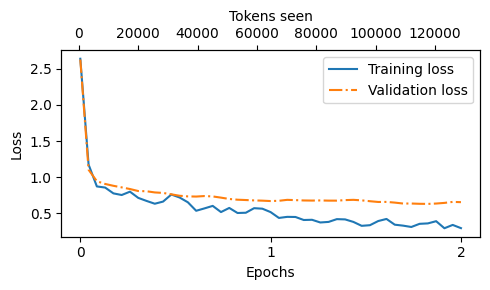

In [38]:
from previous_chapters import plot_losses

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

- 如我们所见，在第一个训练轮次的开始，损失急剧下降，这意味着模型开始迅速学习。
- 大约在训练1个训练轮次时，模型出现了轻微的过拟合。

## 7.7 抽取并保存模型回复

<img src="../image/17.png" width=500px>

- 在本节中，我们保存测试集的响应，以便在下一节进行评估。
- 我们还保存了模型的副本，以备将来使用。
- 但首先，让我们粗略的查看一下微调后的模型生成的响应。

In [39]:
# 设置随机种子，以保证生成结果的可复现性
torch.manual_seed(123)

# 从测试集 test_data 中取前三个样本，逐个生成模型响应并打印结果
for entry in test_data[:3]:

    # 将当前条目的输入格式化为完整的指令输入字符串
    input_text = format_input(entry)

    # 使用模型生成响应对应的 token 序列
    # - model: 当前微调后的语言模型
    # - idx: 经过分词器编码后的输入 token id，并放到计算设备上
    # - max_new_tokens: 限制每次最多生成 256 个新 token
    # - context_size: 上下文最大长度，采用基础配置中的 context_length
    # - eos_id: 指定特殊 token（50256）作为生成终止标记
    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    
    # 将生成得到的 token id 序列解码为文本
    generated_text = token_ids_to_text(token_ids, tokenizer)
    
    # 提取模型真正生成的回复内容（去除输入内容与特殊标记，并去除首尾空格）
    response_text = (
        generated_text[len(input_text):]               # 截掉输入 prompt 部分
        .replace("### Response:", "")                  # 去掉提示标记
        .strip()                                       # 去除首尾空白符
    )

    # 打印格式化好的输入内容
    print(input_text)
    # 打印该条指令的标准参考输出（ground-truth）
    print(f"\nCorrect response:\n>> {entry['output']}")
    # 打印模型生成的输出内容
    print(f"\nModel response:\n>> {response_text.strip()}")
    # 分隔线便于阅读多个样本的输出效果
    print("-------------------------------------")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.

Correct response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a cheetah.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What type of cloud is typically associated with thunderstorms?

Correct response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response:
>> The type of cloud typically associated with thunderstorms is cumulus.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Name the author of 'Pride and Prejudice'.

Correct response:
>> Jane Austen.

Model response:
>> The author of 'Pride and P

- 从测试集中的指令、给定的响应以及模型的响应来看，模型的表现相对较好。
- 第一个和最后一个指令的回答显然是正确的。
- 第二个回答接近正确；模型回答为“积云”（cumulus cloud），而不是“雷雨云”（cumulonimbus）（不过需要注意的是，积云可能发展成雷雨云，而雷雨云具有产生雷暴的能力）。
- 最重要的是，我们可以看到，模型评估结果不像第六章那样直接，因为在第六章中我们只需要计算正确的垃圾邮件/非垃圾邮件类别标签的百分比来获得分类准确率。
- 实际上，指令微调后的LLM（如聊天机器人）通常通过多种方法进行评估：
  - 短答案和多选基准，如MMLU（“大规模多任务语言理解测量”，[https://arxiv.org/abs/2009.03300](https://arxiv.org/abs/2009.03300)），测试模型的知识。
  - 与其他LLM的人工偏好比较，如LMSYS聊天机器人竞技场（[https://arena.lmsys.org](https://arena.lmsys.org)）。
  - 自动化对话基准，其中使用另一个LLM，如GPT-4，来评估响应，例如AlpacaEval（[https://tatsu-lab.github.io/alpaca_eval/](https://tatsu-lab.github.io/alpaca_eval/)）。
- 在下一节中，我们将使用类似AlpacaEval的方法，使用另一个LLM来评估我们模型的响应；不过，我们将使用自己的测试集，而不是公开可用的基准数据集。
- 为此，我们将模型的响应添加到 `test_data` 字典中，并将其保存为 `"instruction-data-with-response.json"` 文件，以便记录，这样我们可以在需要时在单独的Python会话中加载并分析它。

In [40]:
from tqdm import tqdm  # 导入进度条库，用于显示循环进度

# 遍历每一条测试数据，tqdm用于显示处理进度条
for i, entry in tqdm(enumerate(test_data), total=len(test_data)):

    # 针对当前测试样本，格式化输入（如添加前缀/后缀，准备为prompt）
    input_text = format_input(entry)

    # 调用generate函数生成响应
    # - model: 当前的语言模型
    # - idx: 用当前输入文本经过分词器转换得到的token id，并移动到device（CPU/GPU）
    # - max_new_tokens: 限定一次最多生成256个新token，用于控制输出长度
    # - context_size: 设置上下文允许的最大token数
    # - eos_id: 指定特殊token（50256，通常代表<end-of-sequence>）作为终止信号
    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )

    # 将token id列表解码回人类可读文本
    generated_text = token_ids_to_text(token_ids, tokenizer)

    # 去掉输入prompt部分，只保留模型生成的回复内容
    # 同时去除“### Response:”这种标记字符串和首尾空白符
    response_text = generated_text[len(input_text):].replace("### Response:", "").strip()

    # 把模型生成的回复写入到对应测试数据字典中
    # 这样test_data每一项都多了个"model_response"字段，便于之后保存和评估
    test_data[i]["model_response"] = response_text

# 把包含模型回复的完整测试数据保存为json文件
with open("instruction-data-with-response.json", "w") as file:
    json.dump(test_data, file, indent=4)  # 使用indent参数让json输出更具可读性（美观）

100%|██████████| 110/110 [00:36<00:00,  3.00it/s]


- 让我们再检查一下其中一个条目，确认回复是否已正确添加到 `test_data` 中。

In [41]:
print(test_data[0])

{'instruction': 'Rewrite the sentence using a simile.', 'input': 'The car is very fast.', 'output': 'The car is as fast as lightning.', 'model_response': 'The car is as fast as a cheetah.'}


- 最后保存这个模型以便日后复用

In [42]:
import re


file_name = f"{re.sub(r'[ ()]', '', CHOOSE_MODEL) }-sft.pth"
torch.save(model.state_dict(), file_name)
print(f"Model saved as {file_name}")

# Load model via
# model.load_state_dict(torch.load("gpt2-medium355M-sft.pth"))

Model saved as gpt2-medium355M-sft.pth


## 7.8 评价微调后的大语言模型

<img src="../image/18.png" width=500px>

- 在本节中，我们通过使用另一个更强大的LLM来自动化微调后的LLM的响应评估。
- 具体来说，我们使用了Meta AI发布的8B参数指令微调Llama 3模型，该模型可以通过ollama本地运行（[https://ollama.com](https://ollama.com)）。
- （另外，如果您更喜欢通过OpenAI API使用像GPT-4这样的更强大的LLM，请参阅 [llm-instruction-eval-openai.ipynb](../03_model-evaluation/llm-instruction-eval-openai.ipynb) ）

- Ollama 是一个高效运行LLM的程序。
- 它是 llama.cpp 的一个封装器（[https://github.com/ggerganov/llama.cpp](https://github.com/ggerganov/llama.cpp)），该项目使用纯C/C++实现LLM，以最大化效率。
- 请注意，Ollama 是用于生成文本（进行模型推理）的工具，而不是用于训练或微调LLM的工具。
- 在运行以下代码之前，请访问 [https://ollama.com](https://ollama.com) 安装Ollama，并按照指示操作（例如，点击“下载”按钮并下载适用于您操作系统的Ollama应用程序）。

- 对于macOS和Windows用户，点击已下载的ollama应用程序；如果提示安装命令行工具，选择“是”。
- Linux用户可以使用ollama网站上提供的安装命令。

- 通常，在我们通过命令行使用ollama之前，需要先启动ollama应用程序或在单独的终端中运行 `ollama serve`。

<img src="../image/ollama-run.webp" width=700px>

- 在另一个终端运行ollama应用程序或 `ollama serve` 后，在命令行中执行以下命令，尝试使用8B参数的Llama 3模型（该模型占用4.7GB的存储空间，第一次执行此命令时会自动下载）。
```bash
# 8B 模型
ollama run llama3
```


输出可能如下所示

```
$ ollama run llama3
pulling manifest
pulling 6a0746a1ec1a... 100% ▕████████████████▏ 4.7 GB
pulling 4fa551d4f938... 100% ▕████████████████▏  12 KB
pulling 8ab4849b038c... 100% ▕████████████████▏  254 B
pulling 577073ffcc6c... 100% ▕████████████████▏  110 B
pulling 3f8eb4da87fa... 100% ▕████████████████▏  485 B
verifying sha256 digest
writing manifest
removing any unused layers
success
```

- 请注意，`llama3` 指的是经过指令微调的8B参数Llama 3模型。

- 使用ollama与 `"llama3"` 模型（8B参数模型）时需要16GB的RAM；如果您的机器不支持，可以尝试使用更小的模型，例如3.8B参数的phi-3模型，通过设置 `model = "phi-3"`，该模型只需8GB的RAM。

- 如果您的机器支持，您还可以使用更大的70B参数Llama 3模型，只需将 `llama3` 替换为 `llama3:70b`。

- 下载完成后，您将看到一个命令行提示符，可以与模型进行对话。

- 尝试输入类似 "What do llamas eat?" 的提示，模型应返回类似以下的输出：

```
>>> What do llamas eat?
Llamas are ruminant animals, which means they have a four-chambered
stomach and eat plants that are high in fiber. In the wild, llamas
typically feed on:
1. Grasses: They love to graze on various types of grasses, including tall
grasses, wheat, oats, and barley.
```

- 结束运行仅需要输入 `/bye`

- 以下代码检查ollama会话是否正常运行

In [43]:
import psutil

def check_if_running(process_name):
    running = False
    for proc in psutil.process_iter(["name"]):
        if process_name in proc.info["name"]:
            running = True
            break
    return running

ollama_running = check_if_running("ollama")
# 检查运行情况
if not ollama_running:
    raise RuntimeError("Ollama not running. Launch ollama before proceeding.")
print("Ollama running:", check_if_running("ollama"))

Ollama running: True


In [44]:
# 该单元格是可选的；它允许您重新启动notebook
# 并只运行第7.7节，而无需重新运行之前的代码。
import json            # 导入json模块，用于读取和处理JSON数据
from tqdm import tqdm  # 导入tqdm模块，用于显示进度条

# 我们的数据文件路径
file_path = "instruction-data-with-response.json"

# 读取JSON文件并将其内容加载为Python对象
with open(file_path, "r") as file:
    test_data = json.load(file)  # test_data现在是一个包含指令样本的列表，每个样本是一个字典


def format_input(entry):
    """
    将一个数据条目格式化为模型输入的字符串。

    参数:
        entry (dict): 包含'instruction', 'input'等字段的字典

    返回:
        str: 格式化后的输入文本，符合对话/指令-响应格式
    """
    # 先拼接统一的系统说明和指令部分
    instruction_text = (
        f"Below is an instruction that describes a task. "  # 给模型的背景说明
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"     # 实际的指令内容
    )

    # 检查输入数据中是否有“input”字段内容，存在则添加输入部分，否则为空
    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""

    # 返回完整的输入字符串：包含系统提示 + 指令 + （可选）输入字段
    return instruction_text + input_text

- 现在，与我们之前使用的 `ollama run` 命令互动模型的另一种方式是通过其REST API，在Python中通过以下函数进行操作。
- 在运行notebook中的下一个单元格之前，请确保ollama仍在运行（前面的代码单元格应显示 `"Ollama running: True"`）。
- 接下来，运行以下代码单元格来查询模型。

In [45]:
import urllib.request

def query_model(
    prompt,
    model="llama3",
    url="http://localhost:11434/api/chat"
):
    # 预处理的类型与符号
    # 创建数据负载字典
    data = {
        "model": model,
        "messages": [
            {"role": "user", "content": prompt}
        ],
        "options": {     # 以下设置是为了获得确定性的响应
            "seed": 123,
            "temperature": 0,
            "num_ctx": 2048
        }
    }
    

    # 将字典转换为JSON格式的字符串并编码为字节
    payload = json.dumps(data).encode("utf-8")
    # 对JSON进行编码
    # 创建请求对象，设置请求方法为POST并添加必要的头部信息
    request = urllib.request.Request(
        url,
        data=payload,
        method="POST"
    )
    # 设置请求头部为JSON格式
    request.add_header("Content-Type", "application/json")

    # 发送请求并捕获响应
    response_data = ""
    with urllib.request.urlopen(request) as response:
        # 读取并解码响应
        while True:
            line = response.readline().decode("utf-8")
            if not line:
                break
            response_json = json.loads(line)
            response_data += response_json["message"]["content"]

    return response_data


model = "llama3"
result = query_model("What do Llamas eat?", model)
print(result)

Llamas are herbivores, which means they primarily feed on plant-based foods. Their diet typically consists of:

1. Grasses: Llamas love to graze on various types of grasses, including tall grasses, short grasses, and even weeds.
2. Hay: High-quality hay, such as alfalfa or timothy hay, is a staple in a llama's diet. They enjoy munching on hay cubes or loose hay.
3. Grains: Llamas may receive grains like oats, barley, or corn as part of their diet. However, these should be given in moderation to avoid digestive issues.
4. Fruits and vegetables: Fresh fruits and veggies can be a tasty treat for llamas. Some favorites include apples, carrots, sweet potatoes, and leafy greens like kale or spinach.
5. Minerals: Llamas need access to mineral supplements, such as salt licks or loose minerals, to ensure they're getting the necessary nutrients.

In general, a llama's diet should consist of:

* 70-80% grasses and hay
* 10-20% grains and fruits/vegetables
* 5-10% minerals and treats

It's essenti

- 现在，使用我们上面定义的 `query_model` 函数，我们可以评估微调后的模型的响应；让我们在前面一节中查看的前三个测试集响应上试试。

In [46]:
# 遍历测试数据集中前3个条目，对模型的响应进行打分和展示
for entry in test_data[:3]:
    # 为每个测试样本构造一个自定义提示词
    # - format_input(entry): 格式化输入内容（例如，指令或用户输入）
    # - entry['output']: 期望的标准输出
    # - entry['model_response']: 当前模型生成的输出
    # - 提示要求模型根据输入、标准输出与模型输出之间的差异给出 0~100 的分数（100为最优）
    prompt = (
        f"Given the input `{format_input(entry)}` "
        f"and correct output `{entry['output']}`, "
        f"score the model response `{entry['model_response']}`"
        f" on a scale from 0 to 100, where 100 is the best score. "
    )

    # 打印标准输出（理想答案）供人工比对与参考
    print("\nDataset response:")           # 显示数据集中该条目的正确答案
    print(">>", entry['output'])

    # 打印模型生成的输出（实际推断结果）
    print("\nModel response:")             # 显示模型的回答
    print(">>", entry["model_response"])

    # 打印打分结果（模型根据提示打分自身表现）
    print("\nScore:")                      # 显示通过模型打分获得的分数
    print(">>", query_model(prompt))       # 调用query_model提交上面构造的prompt并输出结果

    # 分隔符，便于阅读多个样本的输出
    print("\n-------------------------")


Dataset response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a cheetah.

Score:
>> I'd score this response an 80.

Here's why:

* The model correctly uses a simile ("as fast as") to compare the speed of the car.
* It chooses a relevant and familiar animal (cheetah) that is known for its speed, making the comparison relatable and easy to understand.
* However, while lightning is an extremely fast phenomenon, it's more universally recognized as the fastest thing in the universe. Cheetahs are also very fast, but they're not quite as iconic or widely associated with extreme speed as lightning.

Overall, the response is a good attempt at using a simile to describe the car's speed, and it's close to being excellent. But since lightning is generally considered an even more impressive benchmark for speed, I'd give it 80 out of 100.

-------------------------

Dataset response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Mod

- 如我们所见，Llama 3 模型给出了合理的评估
- 如果模型的回答不完全正确，它会根据部分正确的内容给予相应的分数，例如“积云”这个回答。
- 请注意，之前的提示会返回详细的评估结果；我们可以调整提示，使其生成介于0到100之间的整数分数（其中100为最佳），以便计算模型的平均得分。
- 对测试集中的110个条目进行评估大约需要1分钟(在M3 MacBook Air上运行)。

In [47]:
# 生成模型得分的函数，用于评估模型的输出表现
def generate_model_scores(json_data, json_key, model="llama3"):
    """
    针对一组测试样本，批量让模型自评分数（0~100），返回对应分数序列。

    参数说明：
    - json_data: list
        包含每个测试样本的字典list, 数据格式如[{"input":.., "output":.., json_key:..}, ...]
    - json_key: str
        指定在每个样本字典中用于打分的key（比如 "model_response"）, 代表要评估的答案
    - model: str
        调用评分时用的模型名（如 "llama3"），可根据需求切换不同模型

    返回：
    - scores: list[int]
        每个样本的自评分（int类型），范围 0~100
    """

    scores = []  # 用于存储所有评估得到的分数

    # tqdm用于显示进度条，便于知道处理进度
    for entry in tqdm(json_data, desc="Scoring entries"):
        # 构造打分prompt，要求模型给出0~100的整数评估分数
        prompt = (
            f"Given the input `{format_input(entry)}` "
            f"and correct output `{entry['output']}`, "
            f"score the model response `{entry[json_key]}`"
            f" on a scale from 0 to 100, where 100 is the best score. "
            f"Respond with the integer number only."  # 明确要求只回复数字，方便解析
        )
        # query_model会用指定模型生成回答
        score = query_model(prompt, model)

        # 尝试将结果转成整数，若失败记录异常并继续
        try:
            scores.append(int(score))
        except ValueError:
            print(f"Could not convert score: {score}")  # 打印无法转换的原始模型输出
            continue  # 跳过该条，继续评测下一个样本

    return scores


# 对test_data全部样本进行自评分，指定用"model_response"字段作为模型要评分的内容
scores = generate_model_scores(test_data, "model_response")
print(f"Number of scores: {len(scores)} of {len(test_data)}")  # 打印实际评分条目数
print(f"Average score: {sum(scores)/len(scores):.2f}\n")       # 打印平均分，保留2位小数

Scoring entries: 100%|██████████| 110/110 [00:41<00:00,  2.64it/s]

Number of scores: 110 of 110
Average score: 50.78



- 我们的模型平均得分超过50分，可以将其作为参考，与其他模型进行对比;或尝试其他训练设置来改进模型表现。
- 截至汉化的时候,ollama 在不同操作系统上的结果可能会有所不同，因此您得到的数值可能与上面显示的略有差异。

- 以下看作参考
  - Llama 3 8B 基础模型得分为 58.51
  - Llama 3 8B 指令微调模型得分为 82.65

## 7.9 总结

### 7.9.1 展望

- 本章标志着本书的结束。
- 我们覆盖了LLM开发的主要步骤：实现LLM架构、预训练LLM以及微调模型。

<img src="../image/19.png" width=500px>

- 正如本章所述,指令微调后，有时会进行一个可选步骤——偏好微调.
- 偏好微调有助于定制模型，更好地符合用户偏好。如果您感兴趣，可以查看 [../04_preference-tuning-with-dpo](../04_preference-tuning-with-dpo) 文件夹。

- 本GitHub仓库还包含大量额外的附加资料，您可能会喜欢；有关更多信息，请查看本仓库README页面中的 [Bonus Material](https://github.com/rasbt/LLMs-from-scratch?tab=readme-ov-file#bonus-material) 部分。

### 7.9.2 紧跟时代潮流

- 本节没有代码内容。

### 7.9.3 寄语

- 我希望您喜欢这个从零实现LLM的过程，以及编写预训练和微调代码的过程。
- 在我看来，从零构建大模型是理解LLM如何工作的最佳方式；我希望您通过这种方式获得了更深入的理解。
- 虽然本书是为了教学目的，但您可能有兴趣将不同的、更强大的LLM应用于实际应用中。
  - 为此，您可以考虑使用一些流行工具，如axolotl（[https://github.com/OpenAccess-AI-Collective/axolotl](https://github.com/OpenAccess-AI-Collective/axolotl)）或LitGPT（[https://github.com/Lightning-AI/litgpt](https://github.com/Lightning-AI/litgpt)），这是我参与开发的工具。

## 总结与收获

- 请参阅 [./gpt_instruction_finetuning.py](./gpt_instruction_finetuning.py) 脚本，它是一个自包含的分类微调脚本。
- [./ollama_evaluate.py](./ollama_evaluate.py) 是基于第7.8节的独立脚本，通过Ollama和Llama 3评估包含“output”和“response”键的JSON文件。
- [./load-finetuned-model.ipynb](./load-finetuned-model.ipynb) 笔记本演示了如何在新会话中加载微调后的模型。
- 您可以在 [./exercise-solutions.ipynb](./exercise-solutions.ipynb) 找到习题解答。

## 接下来做什么？

- 恭喜您完成了本书！如果您在寻找更多资源，我在这个GitHub仓库中添加了几个附加部分，您可能会感兴趣。
- 附加资料的完整列表可以在主README的 [Bonus Material](https://github.com/rasbt/LLMs-from-scratch?tab=readme-ov-file#bonus-material) 部分查看。
- 在这里，我想特别强调几个我喜欢的部分：
  1. [从零开始的直接偏好优化（DPO）用于LLM对齐](../04_preference-tuning-with-dpo/dpo-from-scratch.ipynb) 实现了一种流行的偏好调优机制，使本章的模型与人类偏好更加契合。
  2. [从零开始实现Llama 3.2](../../ch05/07_gpt_to_llama/standalone-llama32.ipynb)，这是Meta AI流行的Llama 3.2的从零实现，包括加载官方的预训练权重；如果您想做一些额外的实验，可以将每章中的 `GPTModel` 模型替换为 `Llama3Model` 类（它可以作为1:1替代）。
  3. [将GPT转换为Llama](../../ch05/07_gpt_to_llama) 包含逐步指南的代码，解释了GPT-2和各种Llama模型之间的区别。
  4. [理解嵌入层和线性层的区别](../../ch02/03_bonus_embedding-vs-matmul/embeddings-and-linear-layers.ipynb) 是一个概念性解释，说明了我们在LLM输入阶段使用的PyTorch中的 `Embedding` 层在数学上等价于对独热编码数据应用的线性层。
- 祝您学习愉快！